<a href="https://colab.research.google.com/github/codedog1229/MachineLearning/blob/main/homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW3 Image Classification
## We strongly recommend that you run with Kaggle for this homework
https://www.kaggle.com/c/ml2022spring-hw3b/code?competitionId=34954&sortBy=dateCreated

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
%cd '/content/drive/MyDrive/ML2023/homework3/food11'

/content/drive/MyDrive/ML2023/homework3/food11


In [11]:
%cd '/content/drive/MyDrive/ML2023/homework3'

/content/drive/MyDrive/ML2023/homework3


In [ ]:
! wget https://www.dropbox.com/s/6l2vcvxl54b0b6w/food11.zip

--2023-05-05 12:46:33--  https://www.dropbox.com/s/6l2vcvxl54b0b6w/food11.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/6l2vcvxl54b0b6w/food11.zip [following]
--2023-05-05 12:46:33--  https://www.dropbox.com/s/raw/6l2vcvxl54b0b6w/food11.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 429 Too Many Requests
2023-05-05 12:46:33 ERROR 429: Too Many Requests.



In [ ]:
! unzip train.zip

Archive:  train.zip
   creating: train/
  inflating: train/0_0.jpg           
  inflating: train/0_1001.jpg        
  inflating: train/0_1007.jpg        
  inflating: train/0_1026.jpg        
  inflating: train/0_1027.jpg        
  inflating: train/0_1044.jpg        
  inflating: train/0_1045.jpg        
  inflating: train/0_1060.jpg        
  inflating: train/0_1076.jpg        
  inflating: train/0_1078.jpg        
  inflating: train/0_1088.jpg        
  inflating: train/0_1096.jpg        
  inflating: train/0_1107.jpg        
  inflating: train/0_111.jpg         
  inflating: train/0_1112.jpg        
  inflating: train/0_1126.jpg        
  inflating: train/0_1140.jpg        
  inflating: train/0_1162.jpg        
  inflating: train/0_1176.jpg        
  inflating: train/0_118.jpg         
  inflating: train/0_1183.jpg        
  inflating: train/0_1188.jpg        
  inflating: train/0_1199.jpg        
  inflating: train/0_1222.jpg        
  inflating: train/0_1237.jpg        
  inflatin

In [ ]:
!pwd

/content/drive/MyDrive/ML2023/homework3


# Training

In [12]:
_exp_name = "sample"

In [13]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [14]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## **Transforms**
Torchvision 为图像预处理、数据包装以及数据增强提供了许多有用的实用程序。

有关不同转换的详细信息，请参阅 PyTorch 官网。


In [15]:
# 通常，我们不需要在测试和验证方面进行扩充。
# 我们在这里只需要调整 PIL 图像的大小并将其转换为 Tensor。
test_tfm = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [22]:
# 但是，也可以在测试阶段使用增强。
# 您可以使用 train_tfm 生成各种图像，然后使用集成方法进行测试
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # 你可以在这里添加一些转换。
    transforms.RandomHorizontalFlip(p=0.5), #执行水平翻转的概率为0.5
    transforms.RandomVerticalFlip(p=0.5), #执行上下翻转的概率为0.5
    transforms.RandomRotation(180), #随机旋转
    # ToTensor() 应该是最后一个转换。
    transforms.ToTensor(),
    #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

## **Datasets**
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [17]:
class FoodDataset(Dataset):

  def __init__(self,path,tfm=test_tfm,files = None):
    super(FoodDataset).__init__()
    self.path = path
    self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
    if files!=None:
      self.files = files
    print(f"One {path} sample",self.files[0])
    self.transform = tfm

  def __len__(self):
    return len(self.files)

  def __getitem__(self,idx):
    fname = self.files[idx]
    im = Image.open(fname)
    im = self.transform(im)
    #im = self.data[idx]
    try:
      label = int(fname.split("/")[-1].split("_")[0])
    except:
      label = -1
    return im,label

In [38]:
valid_set = FoodDataset(os.path.join("./food11","validation"), tfm=train_tfm)
valid_set[0]

One ./food11/validation sample ./food11/validation/0_0.jpg


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

In [24]:
unloader = transforms.ToPILImage()

In [31]:
def tensor_to_PIL(tensor):
    image =  tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image

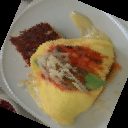

In [39]:
tensor_to_PIL(valid_set[0][0])

In [18]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier,self).__init__()
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    # torch.nn.MaxPool2d(kernel_size, stride, padding)
    # input 維度 [3, 128, 128]
    self.cnn = nn.Sequential(
      nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

      nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

      nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

      nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
      
      nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
    )

    self.fc == nn.Sequential(
      nn.Linear(512*4*4, 1024),
      nn.Dropout(0.2),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.Dropout(0.2),
      nn.ReLU(),
      nn.Linear(512, 11)
    )

  def forward(self, x):
    out = self.cnn(x)
    out = out.view(out.size()[0],-1)
    return self.fc(out)
  

In [7]:
x = torch.randn(4, 4)
x.size()
y = x.view(x.size()[0],-1)
x,y

(tensor([[ 0.7794, -0.1769, -0.4445,  0.5650],
         [ 1.1334, -0.0135,  1.1745,  0.2932],
         [ 1.1668, -0.3385, -0.2291,  0.6079],
         [ 2.6730, -0.0449,  0.9456,  0.7026]]),
 tensor([[ 0.7794, -0.1769, -0.4445,  0.5650],
         [ 1.1334, -0.0135,  1.1745,  0.2932],
         [ 1.1668, -0.3385, -0.2291,  0.6079],
         [ 2.6730, -0.0449,  0.9456,  0.7026]]))

In [19]:
batch_size = 64
_dataset_dir = "./food11"
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset(os.path.join(_dataset_dir,"training"), tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset(os.path.join(_dataset_dir,"validation"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

FileNotFoundError: ignored

One ./food11/validation sample ./food11/validation/0_0.jpg


(tensor([[[0.0471, 0.0392, 0.0431,  ..., 0.6196, 0.6235, 0.6196],
          [0.0510, 0.0471, 0.0588,  ..., 0.6157, 0.6235, 0.6196],
          [0.0588, 0.0627, 0.0784,  ..., 0.6196, 0.6196, 0.6196],
          ...,
          [0.3882, 0.3922, 0.3882,  ..., 0.6078, 0.6000, 0.5961],
          [0.4000, 0.4039, 0.3961,  ..., 0.6078, 0.6039, 0.5961],
          [0.4118, 0.4118, 0.4039,  ..., 0.6078, 0.6078, 0.5843]],
 
         [[0.0392, 0.0392, 0.0431,  ..., 0.6000, 0.6039, 0.6000],
          [0.0471, 0.0471, 0.0627,  ..., 0.5961, 0.6039, 0.6000],
          [0.0549, 0.0667, 0.0824,  ..., 0.5961, 0.5961, 0.5961],
          ...,
          [0.3882, 0.3843, 0.3765,  ..., 0.6039, 0.6000, 0.5961],
          [0.4000, 0.3961, 0.3843,  ..., 0.6039, 0.6000, 0.5922],
          [0.4118, 0.4078, 0.3922,  ..., 0.6039, 0.6039, 0.5725]],
 
         [[0.0431, 0.0471, 0.0549,  ..., 0.5922, 0.5961, 0.5922],
          [0.0588, 0.0627, 0.0824,  ..., 0.5843, 0.5882, 0.5843],
          [0.0784, 0.0902, 0.1137,  ...,

In [8]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# The number of training epochs and patience.
n_epochs = 4
patience = 300 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) 

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

NameError: ignored

In [ ]:
for epoch in range(n_epochs):

    # ---------- Training ----------
    # 训练前确保模型处于训练模式。
    model.train()

    # 这些用于记录训练中的信息。
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # 一个批次由图像数据和相应的标签组成。
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # 转发数据。 （确保数据和模型在同一台设备上。）
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # 我们不需要在计算交叉熵之前应用 softmax，因为它是自动完成的。
        loss = criterion(logits, labels.to(device))

        # 需要先清除上一步参数中存储的梯度。
        optimizer.zero_grad()

        # 计算参数的梯度。
        loss.backward()

        # 剪裁梯度规范以进行稳定训练。
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # 使用计算出的梯度更新参数。
        optimizer.step()

        # 计算当前批次的准确度。
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # 记录损失和准确性。
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # 打印信息。
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # 确保模型处于评估模式，以便某些模块（如 dropout）被禁用并正常工作。
    model.eval()

    # 这些用于记录验证中的信息。
    valid_loss = []
    valid_accs = []

    # 分批迭代验证集。
    for batch in tqdm(valid_loader):

        # 一个批次由图像数据和相应的标签组成。
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # 使用 torch.no_grad() 加速前进过程。
        with torch.no_grad():
            logits = model(imgs.to(device))

        # 我们仍然可以计算损失（但不是梯度）。
        loss = criterion(logits, labels.to(device))

        # 计算当前批次的准确度。
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # 记录损失和准确性。
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # 整个验证集的平均损失和准确度是记录值的平均值。
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # 打印信息。
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # 更新日志
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # 保存模型
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

In [ ]:
test_set = FoodDataset(os.path.join(_dataset_dir,"test"), tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Testing and generate prediction CSV

In [ ]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in test_loader:
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

In [ ]:
#create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(1,len(test_set)+1)]
df["Category"] = prediction
df.to_csv("submission.csv",index = False)

# Q1。 增强实现
## 通过在代码中使用您选择的图像大小完成 train_tfm 来实现增强。
## 代码写完后直接复制下面的block粘贴到GradeScope
### 当多次给出相同的图像时，您的 train_tfm 必须能够产生 5+ 个不同的结果。
### 报告中的 train_tfm 可以与训练代码中的 train_tfm 不同。

In [ ]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You need to add some transforms here.
    transforms.ToTensor(),
])

# Q2. Residual Implementation
![](https://i.imgur.com/GYsq1Ap.png)
## Directly copy the following block and paste it on GradeScope after you finish the code


In [ ]:
from torch import nn
class Residual_Network(nn.Module):
    def __init__(self):
        super(Residual_Network, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
        )

        self.cnn_layer4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
        )
        self.cnn_layer5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
        )
        self.cnn_layer6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(256* 32* 32, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x1 = self.cnn_layer1(x)
        
        x1 = self.relu(x1)
        
        x2 = self.cnn_layer2(x1)
        
        x2 = self.relu(x2)
        
        x3 = self.cnn_layer3(x2)
        
        x3 = self.relu(x3)
        
        x4 = self.cnn_layer4(x3)
        
        x4 = self.relu(x4)
        
        x5 = self.cnn_layer5(x4)
        
        x5 = self.relu(x5)
        
        x6 = self.cnn_layer6(x5)
        
        x6 = self.relu(x6)
        
        # The extracted feature map must be flatten before going to fully-connected layers.
        xout = x6.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        xout = self.fc_layer(xout)
        return xout